In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
data = pd.read_csv('../prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.index = pd.date_range(start="2001-01-01", periods=len(data), freq="M")
data.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13380\1497351758.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start="2001-01-01", periods=len(data), freq="M")


,index,month,prcp
2001-01-31,0,2001-01-01,101.400000
2001-02-28,1,2001-02-01,98.200000
2001-03-31,2,2001-03-01,201.200000
2001-04-30,3,2001-04-01,141.200000
2001-05-31,4,2001-05-01,29.233333


<Figure size 2000x1000 with 0 Axes>

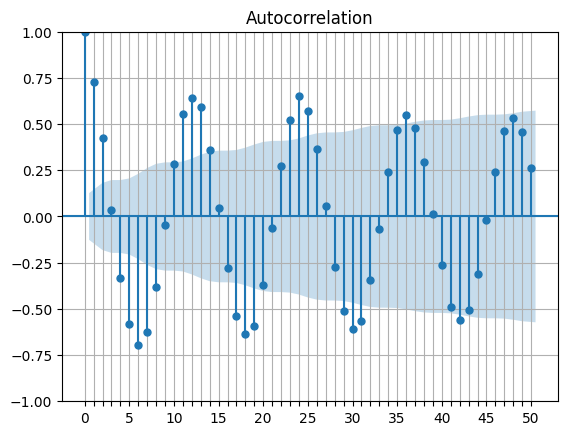

In [ ]:
plt.figure(figsize=(20, 10))
plot_acf(data['prcp'], lags=50)
plt.xticks(ticks=range(0, 51), labels=[str(x) if x % 5 == 0 else '' for x in range(0, 51)]) 
plt.grid(True)  
# plt.savefig('../stationary_check/acf.png')
plt.show()

Lag = 1, 2 cho độ tự tương quan tương đối tốt -> xem xét sử dụng mô hình AR(1) hoặc AR(2)

## Train model:

#### Train test split:

In [5]:
train = data[data['month'].dt.year <= 2015]
test = data[data['month'].dt.year > 2015]

#### AR(1):

In [6]:
ar1 = AutoReg(train['prcp'], lags=1).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   prcp   No. Observations:                  180
Model:                     AutoReg(1)   Log Likelihood                -984.176
Method:               Conditional MLE   S.D. of innovations             59.101
Date:                Thu, 20 Feb 2025   AIC                           1974.353
Time:                        13:04:38   BIC                           1983.915
Sample:                    02-28-2001   HQIC                          1978.230
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.2328      7.560      4.528      0.000      19.415      49.051
prcp.L1        0.7075      0.053     13.381      0.000       0.604       0.811
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4135           +0.0000j            1.4135            0.0000
-----------------------------------------------------------------------------
"""

- Dựa vào p-value, ta thấy rằng biến y_t-1 thực sự khác 0, do đó, nó có ý nghĩa trong việc dự báo

Forecasting:

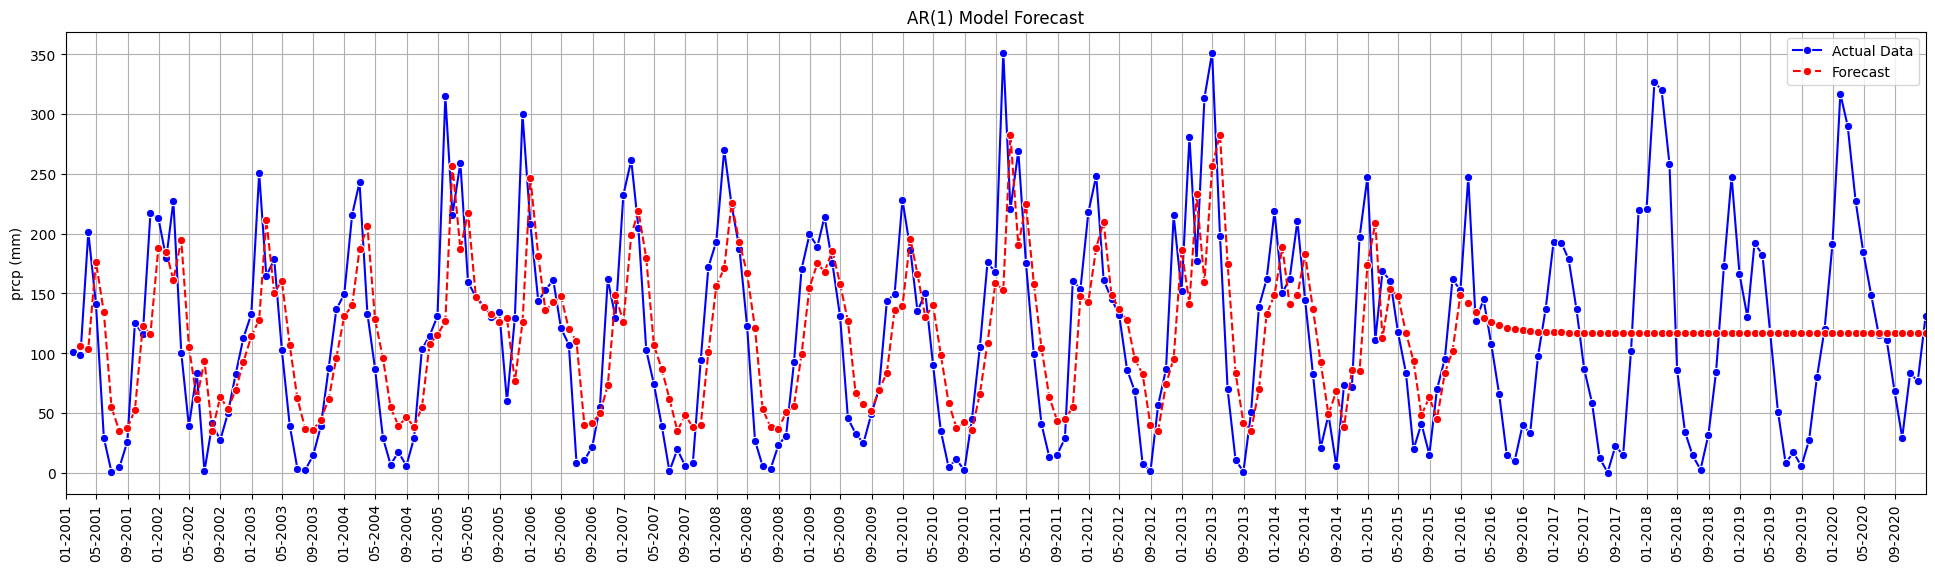

In [7]:
forecast_lag1 = ar1.predict(start=0, end=len(data)-1)

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(forecast_lag1, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("AR(1) Model Forecast")
plt.legend()
# plt.savefig('forecast/ar1.png')
plt.show()

Residual evaluation:

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast_lag1[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast_lag1[-60:])
r2 = r2_score(test['prcp'], forecast_lag1[-60:])
aic = ar1.aic
bic = ar1.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 7830.01
RMSE: 88.49
MAE: 73.04
R²: 0.007
AIC: 1974.35
BIC: 1983.91


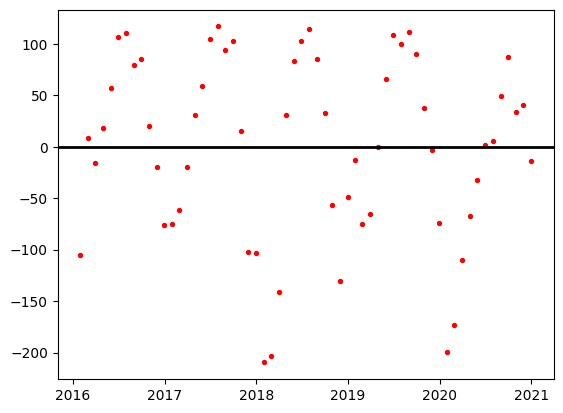

In [9]:
plt.scatter(forecast_lag1[-60:].index, forecast_lag1[-60:] - test['prcp'], color="red", s=8)
plt.axhline(0, color='black', lw=2)
plt.show()

#### AR(2):

Fit model:

In [10]:
ar2 = AutoReg(train['prcp'], lags=2).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   prcp   No. Observations:                  180
Model:                     AutoReg(2)   Log Likelihood                -976.572
Method:               Conditional MLE   S.D. of innovations             58.406
Date:                Thu, 20 Feb 2025   AIC                           1961.145
Time:                        13:06:10   BIC                           1973.872
Sample:                    03-31-2001   HQIC                          1966.306
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0171      7.888      5.073      0.000      24.557      55.477
prcp.L1        0.8272      0.074     11.199      0.000       0.682       0.972
prcp.L2       -0.1697      0.074     -2.295      0.022      -0.315      -0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2167           +0.0000j            2.2167            0.0000
AR.2            2.6588           +0.0000j            2.6588            0.0000
-----------------------------------------------------------------------------
"""

- Dựa vào p-value, ta thấy rằng biến y_t-2 thực sự khác 0, do đó, nó có ý nghĩa trong việc dự báo

Forecasting:

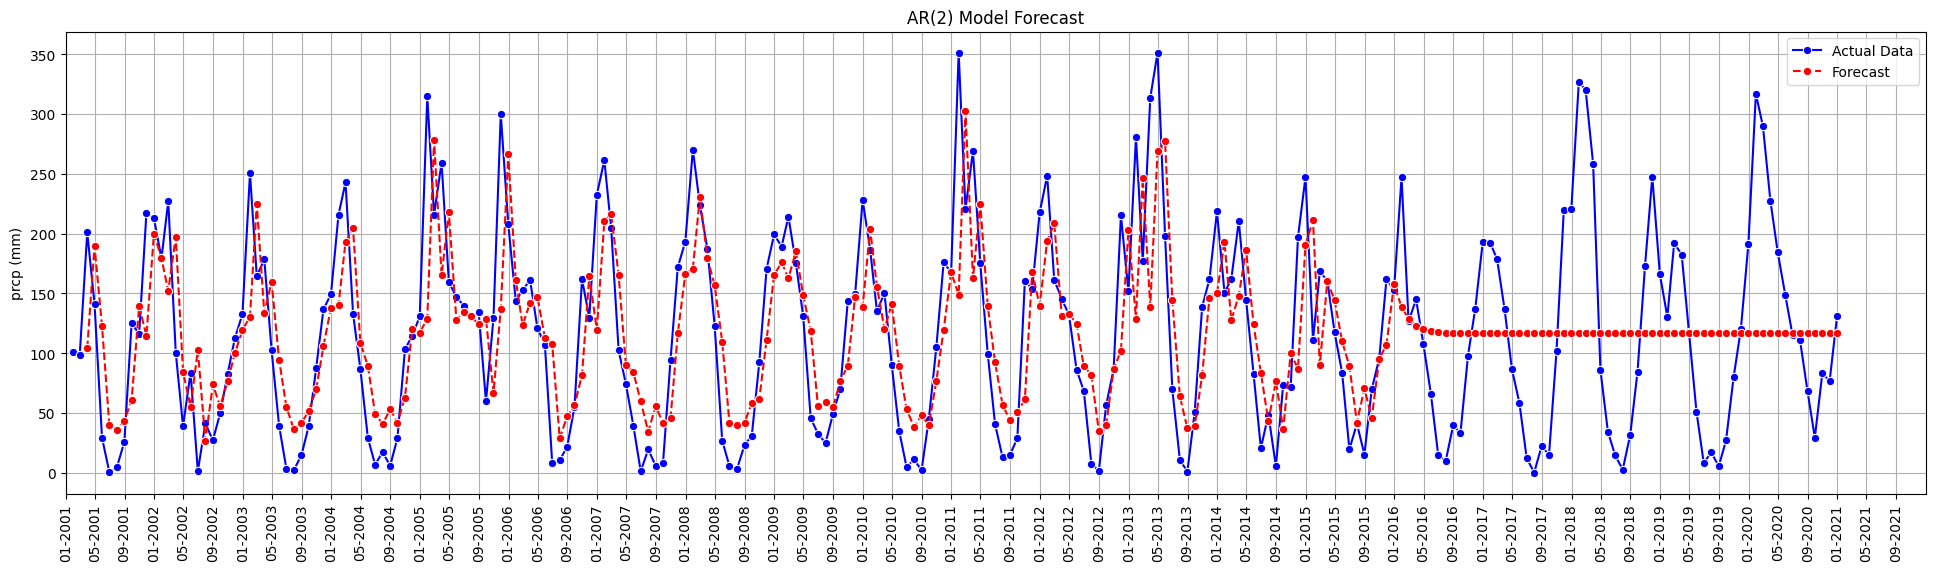

In [11]:
forecast_lag2 = ar2.predict(start=0, end=len(data)-1)

# Vẽ kết quả
plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(forecast_lag2, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2021-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("AR(2) Model Forecast")
plt.legend()
# plt.savefig('forecast/ar2.png')
plt.show()

Residual evaluation:

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast_lag2[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast_lag2[-60:])
r2 = r2_score(test['prcp'], forecast_lag2[-60:])
aic = ar2.aic
bic = ar2.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 7802.46
RMSE: 88.33
MAE: 72.75
R²: 0.010
AIC: 1961.14
BIC: 1973.87


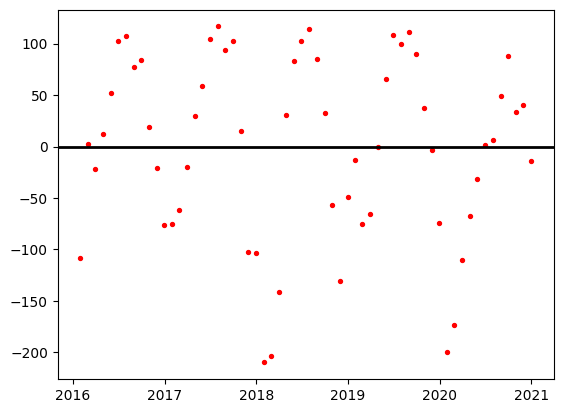

In [13]:
plt.scatter(forecast_lag2[-60:].index, forecast_lag2[-60:] - test['prcp'], color="red", s=8)
plt.axhline(0, color='black', lw=2)
plt.show()